# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat  PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

$$\Large F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $$

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
import scipy.optimize as opt
import scipy.stats as stats

In [911]:
import warnings
warnings.simplefilter('ignore')

## Background Info and Separating Data

In [714]:
d1=pd.read_csv('PS1_PS1MD_PSc000098.snana.dat',header=14,sep='\s+',skipfooter=1,engine='python')
# d1g = d1.query('FLT == "g"')
d2=pd.read_csv('PS1_PS1MD_PSc000174.snana.dat',header=14,sep='\s+',skipfooter=1,engine='python')
bands=d1["FLT"].unique()
star1 = [d1.query(f'FLT == "{band}"') for band in bands]
star2 = [d2.query(f'FLT == "{band}"') for band in bands]

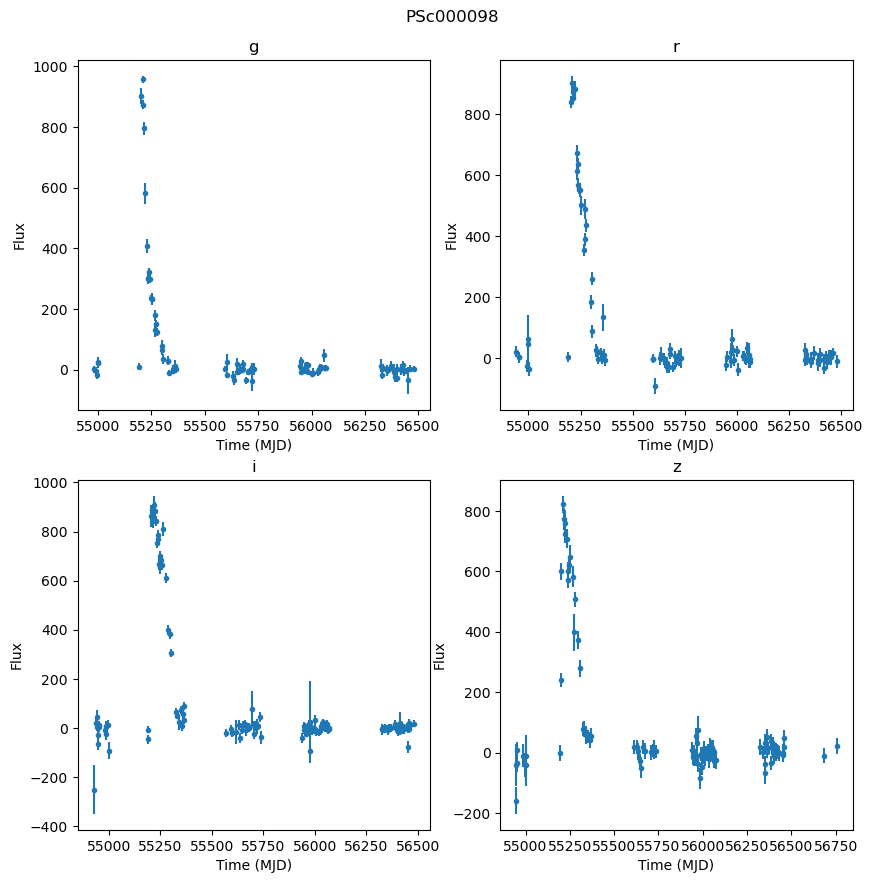

In [936]:
plt.figure(figsize=(10,10))
plt.suptitle('PSc000098',y=0.93)
# lv =[]
for i in range(len(star1)):
    plt.subplot(int(f"22{i+1}"))
    plt.title(bands[i])
    plt.ylabel('Flux')
    plt.xlabel('Time (MJD)')
    plt.errorbar(star1[i].MJD,star1[i].FLUXCAL,yerr=star1[i].FLUXCALERR,linestyle='None', marker='.')

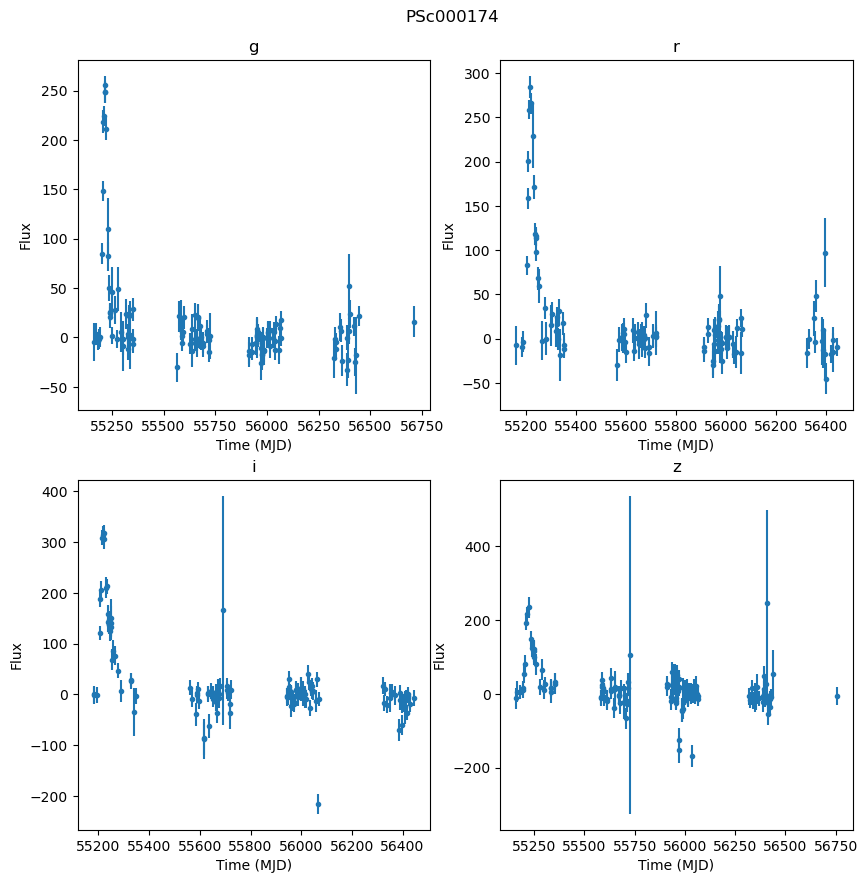

In [935]:
plt.figure(figsize=(10,10))
plt.suptitle('PSc000174',y=0.93)
# lv =[]
for i in range(len(star2)):
    plt.subplot(int(f"22{i+1}"))
    plt.title(bands[i])
    plt.ylabel('Flux')
    plt.xlabel('Time (MJD)')
    plt.errorbar(star2[i].MJD,star2[i].FLUXCAL,yerr=star2[i].FLUXCALERR,linestyle='None',marker='.')

## The Model

|Parameter| Description| Prior |
|--------:|-----------:|:------|
|τrise (days) |Rise Time |U(0.01,50)|
|τfall (days) |Decline Time| U(1,300)|
|t0 (MJD) |“Start” Time| U(tmin − 50, tmax + 300)|
|A| Amplitude| U(3σ,100 Fmax)|
|β (flux/day)| Plateau slope| U(−Fmax/150,0)|
|c (flux) |Baseline Flux| U(−3σ,3σ)|
|γ (days) |Plateau duration|(2/3)N(5, 5) + (1/3) N(60, 30) |

She used equation 1, defined here: https://arxiv.org/abs/1905.07422

$$\Large F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $$

In [1033]:
def fmod(t,A,b,tr,tf,t0,g):
    t1=g+t0
    fluxa = np.zeros_like(t)
    mask = t<t1
    ug1= A+b*(t-t0)
    ug2=1+np.exp(-(t-t0)/tr)
    fluxa[mask] = (ug1/ug2)[mask]
    ug3 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
    ug4 = 1+np.exp((-t-t0)/tr)
    fluxa[~mask] = (ug3/ug4)[~mask]
    return np.nan_to_num(fluxa)

## The Likelihood

In [175]:
def loss(vl,data):
    og=(data.FLUXCAL.values-fmod(data.MJD.values,vl[0],vl[1],vl[2],vl[3],vl[4],vl[5]))**2/(2*data.FLUXCALERR.values)**2
    return np.sum(og)
def LogLike(A,b,tr,tf,t0,t1,data):
    args = (A,b,tr,tf,t0,t1)
    return -loss(args,data)

## The Prior (and bounds)

(array([ 2.,  2., 22., 42., 59., 45., 21.,  6.,  0.,  1.]),
 array([-12.99754512,  -5.13057481,   2.7363955 ,  10.60336582,
         18.47033613,  26.33730644,  34.20427676,  42.07124707,
         49.93821738,  57.8051877 ,  65.67215801]),
 <BarContainer object of 10 artists>)

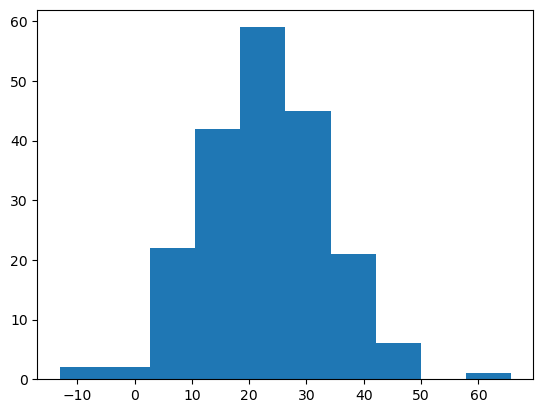

In [479]:
plt.hist(2/3*stats.norm.rvs(loc=5,scale=5,size=200)+(1/3)*stats.norm.rvs(loc=60,scale=30,size=200))

|Parameter| Description| Prior |
|--------:|-----------:|:------|
|τrise (days) |Rise Time |U(0.01,50)|
|τfall (days) |Decline Time| U(1,300)|
|t0 (MJD) |“Start” Time| U(tmin − 50, tmax + 300)|
|A| Amplitude| U(3σ,100 Fmax)|
|β (flux/day)| Plateau slope| U(−Fmax/150,0)|
|c (flux) |Baseline Flux| U(−3σ,3σ)|
|γ (days) |Plateau duration|(2/3)N(5, 5) + (1/3) N(60, 30) |

For my bounds, I made them more concise than whats given in the paper since I will need to fit only two SNe. You can find the bounds in the two functions below (`boundf()` and `boundf2()`). The bounds for gamma were chosen from the edges of the histogram of the two normal distributions given for the prior in the paper.

In [999]:
def LogPrior(A,b,tr,tf,t0,t1,data,bounds):
    # bounds go here
    if (A >=bounds[0][1] or A <= bounds[0][0]) or\
    (tf >= bounds[3][1] or tf<= bounds[3][0]) or\
    (t0>=bounds[4][1] or t0<= bounds[4][0]) or\
    (b >=bounds[1][1] or b<=bounds[1][0])or\
    (tr >= bounds[2][1] or tr<=bounds[2][0]) or\
    (t1 >= bounds[5][1] or t1<=bounds[5][0]):
        # print('fail')
        return -np.inf

    prior = 2/3*stats.norm.pdf(t1,loc=5,scale=5)+(1/3)*stats.norm.pdf(t1,loc=60,scale=30)
    # print(prior)
    lnprior = np.log(prior)
    return lnprior

In [1000]:
def LogPosterior(params,data,bounds):
    A,b,tr,tf,t0,t1 = params
    lnlike = LogLike(*params,data)
    lnprior = LogPrior(*params,data,bounds)
    return lnprior+lnlike

In [862]:
#A,b,tr,tf,t0,g
def boundf(data):
    #A,b,tr,tf,t0,g
    bounds = [(data.FLUXCAL.values.max()-50,50+data.FLUXCAL.values.max()),
          (-data.FLUXCAL.values.max()/150,0),
          (0.01,50),
          (1,300),
          (data.MJD.values[np.argmax(d1g.FLUXCAL.values)]-50,data.MJD.values[np.argmax(data.FLUXCAL.values)]+100),
          (-10,60)]
    return bounds

In [997]:
# bounds for second SNe
def boundf2(data):
    #A,b,tr,tf,t0,g
    bounds = [(data.FLUXCAL.values.max()-100,data.FLUXCAL.values.max()+50),
            # (200,400),
          (-data.FLUXCAL.values.max()/150,0),
          (0.01,50),
          (1,300),
          (data.MJD.values.min(),55300),
          (-10,60)]
    return bounds

## The Sample

In [726]:
ndim=6
nwalkers=20

def guess_gen(bounds):
    starting_guesses = np.zeros((nwalkers, ndim))
    for i in range(ndim):
        starting_guesses[:, i] = np.random.uniform(low=bounds[i][0],high=bounds[i][1],size=starting_guesses[:,i].shape)
    
    # guess for gamma
    starting_guesses[:,-1] = 2/3*stats.norm.rvs(loc=5,scale=5,size=len(starting_guesses[:,-1]))\
    +(1/3)*stats.norm.rvs(loc=60,scale=30,size=len(starting_guesses[:,-1]))
    return starting_guesses

In [894]:
%%time
samples=[]
for i in range(len(star1)):
    bounds= boundf(star1[i])
    starting_guesses=guess_gen(bounds)
    kwargs = {'data':star1[i],'bounds':bounds}
    sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs=kwargs )
    sampler.run_mcmc(starting_guesses, 30_00,progress=True)
    samples.append(sampler.get_chain(flat=True))

You must install the tqdm library to use progress indicators with emcee
/tmp/ipykernel_11002/3029091939.py:19: RuntimeWarning: overflow encountered in exp
  ug2=1+np.exp(-(t-t0)/tr)
/tmp/ipykernel_11002/3029091939.py:22: RuntimeWarning: overflow encountered in exp
  ug4 = 1+np.exp((-t-t0)/tr)
/tmp/ipykernel_11002/3029091939.py:21: RuntimeWarning: overflow encountered in exp
  ug3 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
/tmp/ipykernel_11002/3618467147.py:2: RuntimeWarning: overflow encountered in square
  og=(data.FLUXCAL.values-fmod(data.MJD.values,vl[0],vl[1],vl[2],vl[3],vl[4],vl[5]))**2/(2*data.FLUXCALERR.values)**2
/tmp/ipykernel_11002/3029091939.py:21: RuntimeWarning: overflow encountered in multiply
  ug3 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarni

CPU times: user 1min 24s, sys: 344 ms, total: 1min 25s
Wall time: 2min 7s


In [1003]:
%%time
samples2=[]
for i in range(len(star2)):
    bounds2= boundf2(star2[i])
    starting_guesses=guess_gen(bounds2)
    kwargs = {'data':star2[i],'bounds':bounds2}
    sampler2 = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs=kwargs )
    sampler2.run_mcmc(starting_guesses, 10_00,progress=True)
    samples2.append(sampler2.get_chain(flat=True))

You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee


CPU times: user 18 s, sys: 203 ms, total: 18.2 s
Wall time: 27 s


## Corner Plots
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)



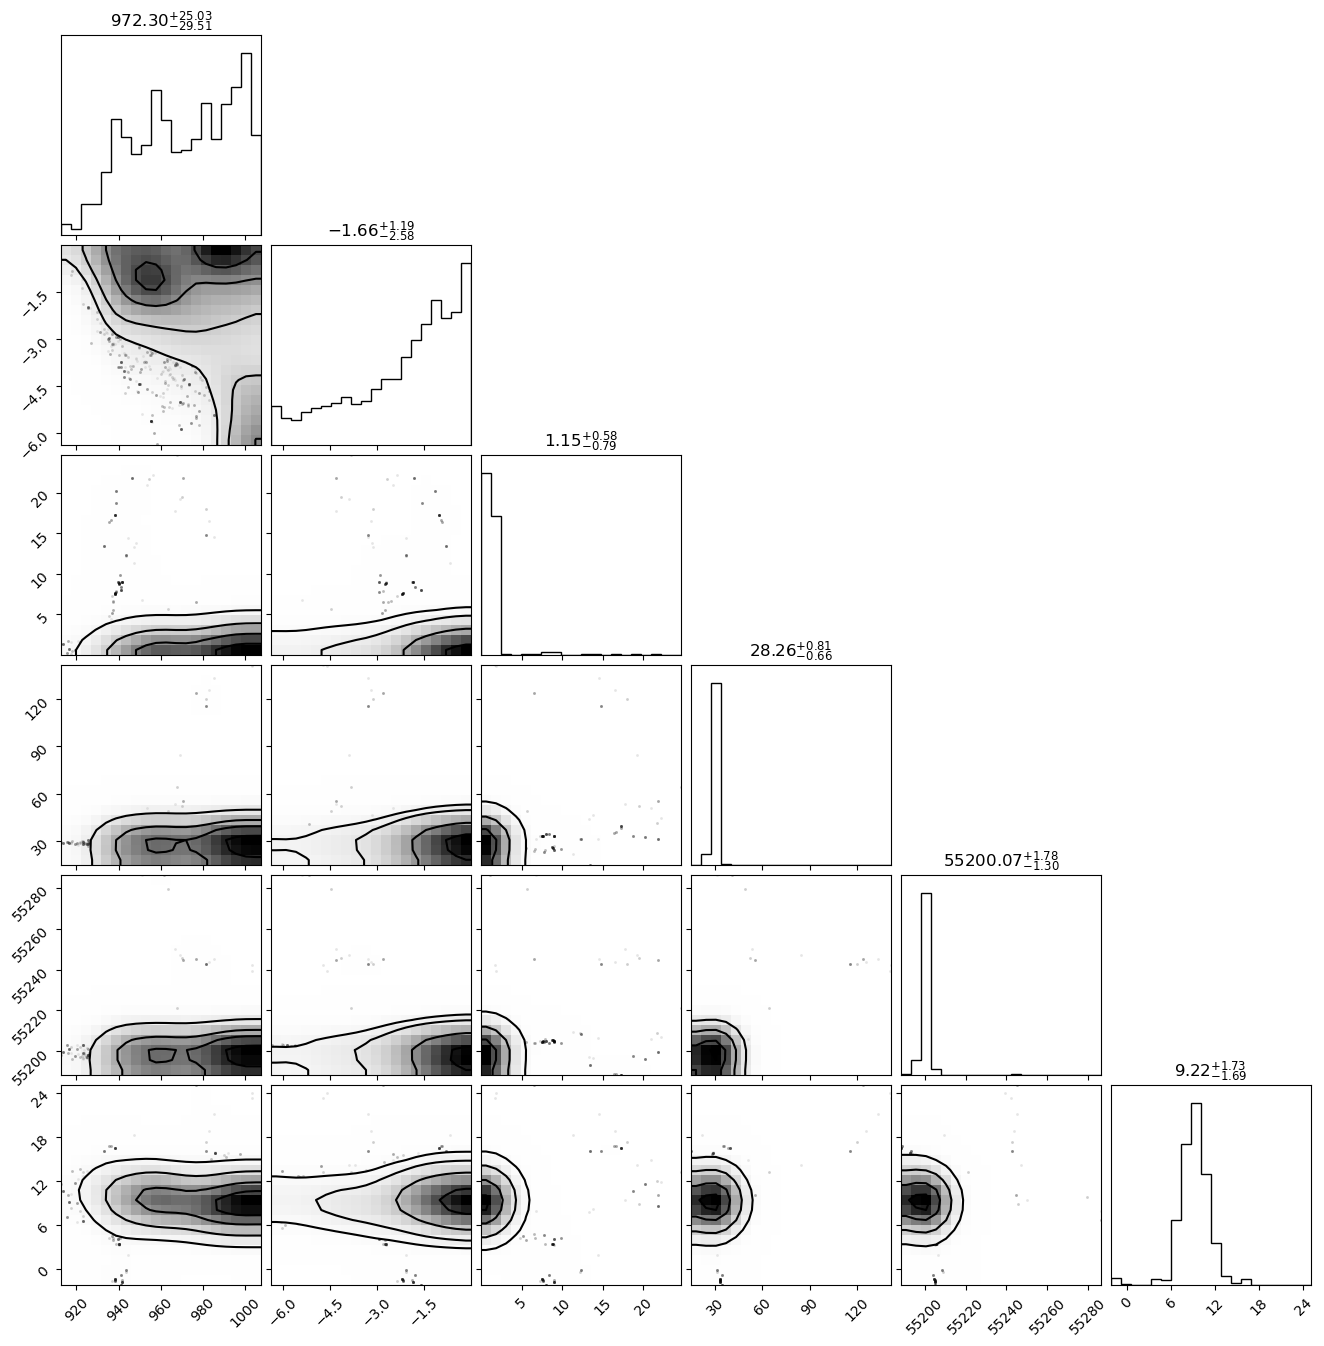

In [1006]:
sc = samples[0]
fig = corner.corner(sc[::10,:], plot_contours=True, show_titles=True, smooth=2)

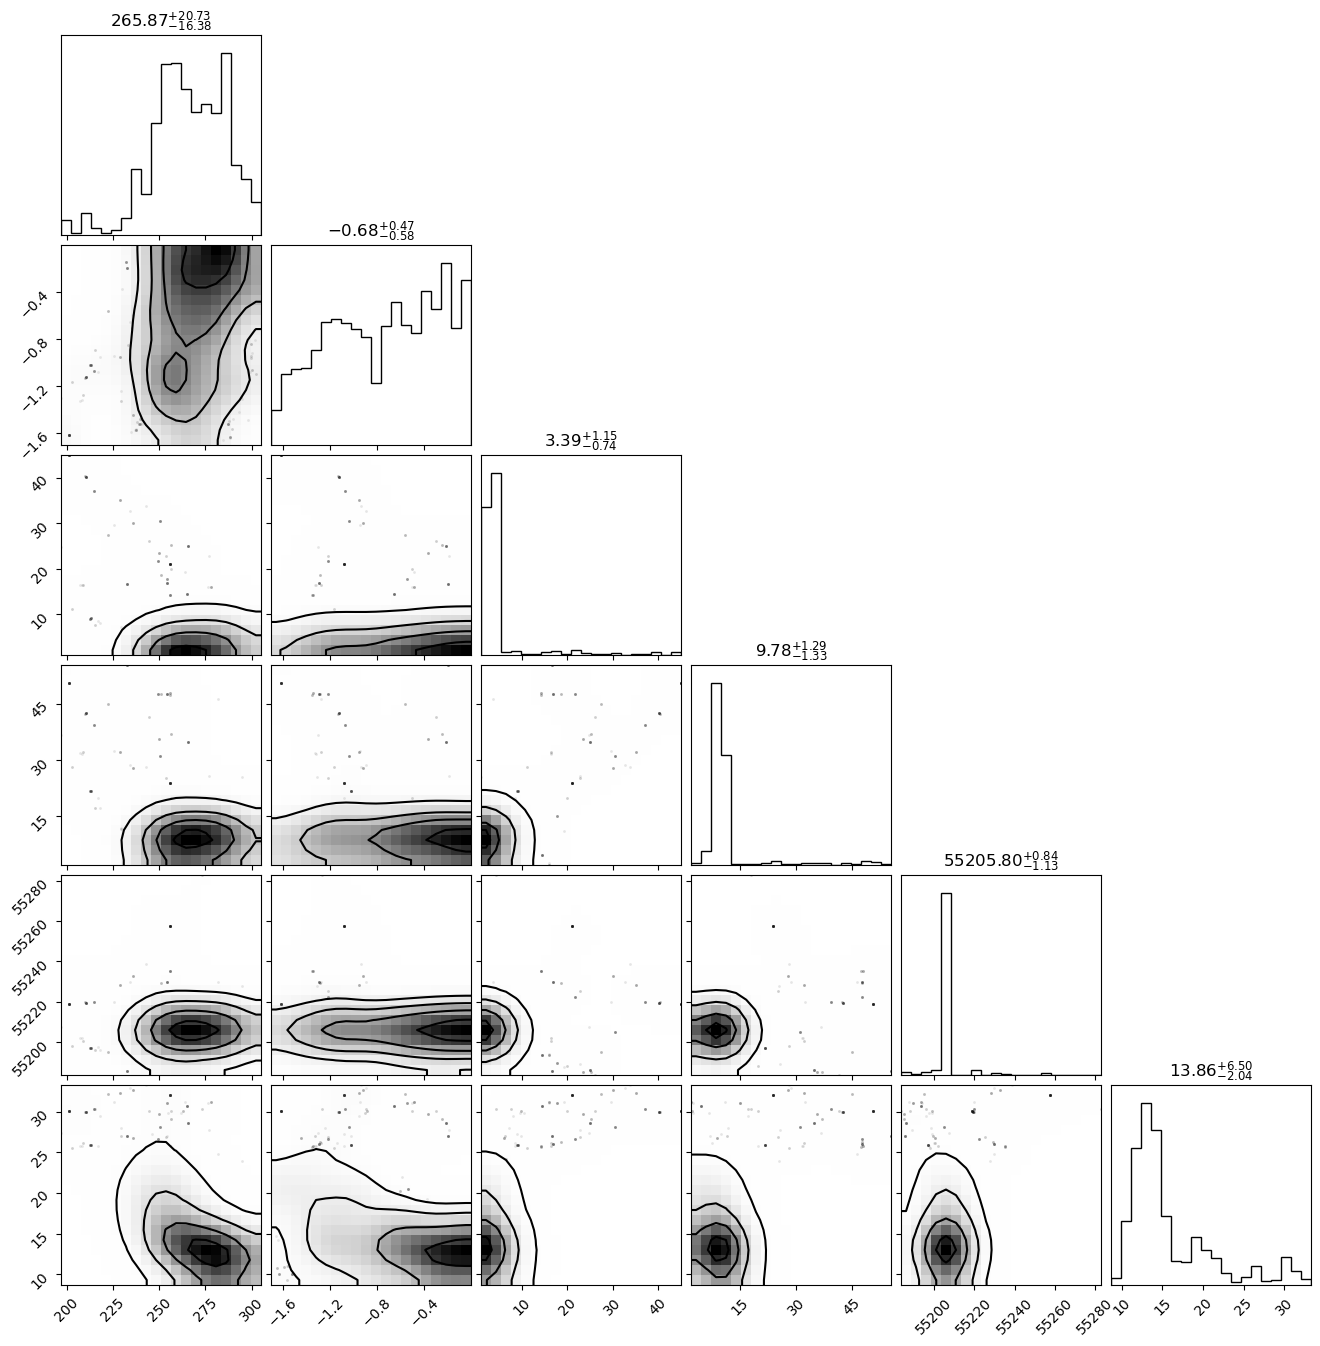

In [1004]:
sc2 = samples2[0]
fig = corner.corner(sc2[::10,:], plot_contours=True, show_titles=True, smooth=2)

## Recreating the Plots



Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)



The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 120;
tau: [142.13108646]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 120;
tau: [154.77691319]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1200;
tau: [1281.77951172]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 120;
tau: [337.45690749]


band g, no thinning, autocorr = 130.45985304794885
band g, thinned, autocorr = 142.13108645862738
band r, no thinning, autocorr = 660.331599988719
band r, thinned, autocorr = 154.7769131861654
band i, no thinning, autocorr = 1281.7795117190665
band i, thinned, autocorr = 337.4569074907498


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1200;
tau: [1529.43586853]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 120;
tau: [239.15565579]


band z, no thinning, autocorr = 1529.4358685252257
band z, thinned, autocorr = 239.15565579322885


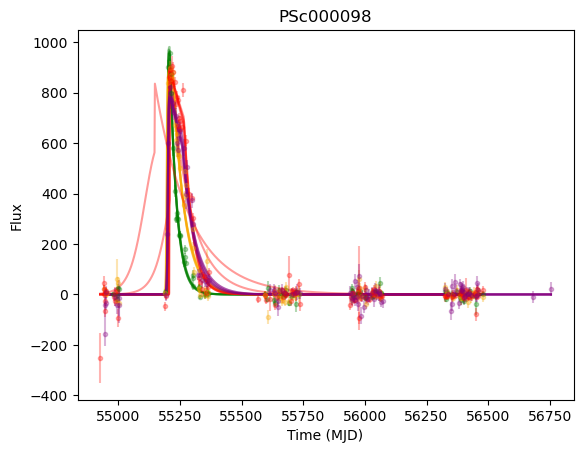

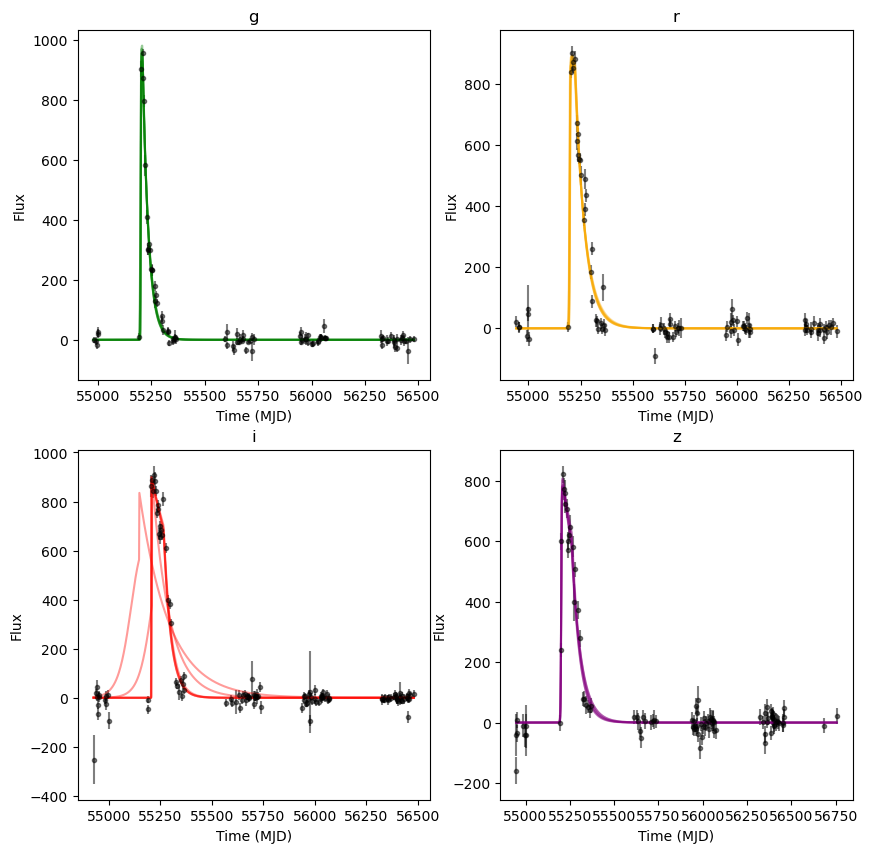

In [937]:
# warnings.simplefilter('ignore')
colors = ['#007f00','#f8a800','#ff0700','#84007f']
rsams=[]
for i in range(len(star1)):
    sam=samples[i]
    try:
        print(f'band {bands[i]}, no thinning, autocorr =',emcee.autocorr.integrated_time(sam,quiet=True)[0])
        print(f'band {bands[i]}, thinned, autocorr =',emcee.autocorr.integrated_time(sam[::10,:],quiet=True)[0])
    except:
        print('autocorr broke')
        pass
    rsam = sam[np.random.randint(0,sam.shape[0],size=5)]
    rsams.append(rsam)
    # mcmc_res = np.percentile(sam,50,axis=0)
    med= np.median(sam,axis=0)
    plt.title('PSc000098')
    plt.xlabel('Time (MJD)')
    plt.ylabel('Flux')
    # plt.scatter(star1[i].MJD,star1[i].FLUXCAL,color=colors[i])
    plt.errorbar(star1[i].MJD,star1[i].FLUXCAL,yerr=star1[i].FLUXCALERR,linestyle='None', marker='.',color=colors[i],alpha=0.3)
    xv=np.linspace(star1[i].MJD.min(),star1[i].MJD.max(),1000)
    pv=plt.plot(xv,fmod(xv,*med),color=colors[i],alpha=0.4)
    for j in range(len(rsam)):
        plt.plot(xv,fmod(xv,*rsam[j]),color=colors[i],alpha=0.4)
    # plt.plot(xv,fmod(xv,*med),color=colors[i],alpha=0.1)
plt.figure(figsize=(10,10))
i=0
j=0
for i in range(len(star1)):
    plt.subplot(int(f"22{i+1}"))
    plt.title(bands[i])
    plt.xlabel('Time (MJD)')
    plt.ylabel('Flux')
    sam=samples[i]
    mcmc_res = np.percentile(sam,50,axis=0)
    med= np.median(sam,axis=0)
    # plt.scatter(star1[i].MJD,star1[i].FLUXCAL,color=colors[i])
    plt.errorbar(star1[i].MJD,star1[i].FLUXCAL,yerr=star1[i].FLUXCALERR,linestyle='None', marker='.',color='k',alpha=0.5)
    xv=np.linspace(star1[i].MJD.min(),star1[i].MJD.max(),1000)
    plt.plot(xv,fmod(xv,*mcmc_res),color=colors[i],alpha=0.4)
    # j=0
    for j in range(len(rsams[i])):
        plt.plot(xv,fmod(xv,*rsams[i][j]),color=colors[i],alpha=0.4)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1136.29150123]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [142.71294486]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1013.30869391]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [127.26221954]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1255.69773113]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate 

band g, no thinning, autocorr = 1136.291501231689
band g, thinned, autocorr = 142.712944863232
band r, no thinning, autocorr = 1013.3086939106057
band r, thinned, autocorr = 127.26221953983989
band i, no thinning, autocorr = 1255.697731132423
band i, thinned, autocorr = 170.348494475337
band z, no thinning, autocorr = 273.7167326826478
band z, thinned, autocorr = 57.99568270863045


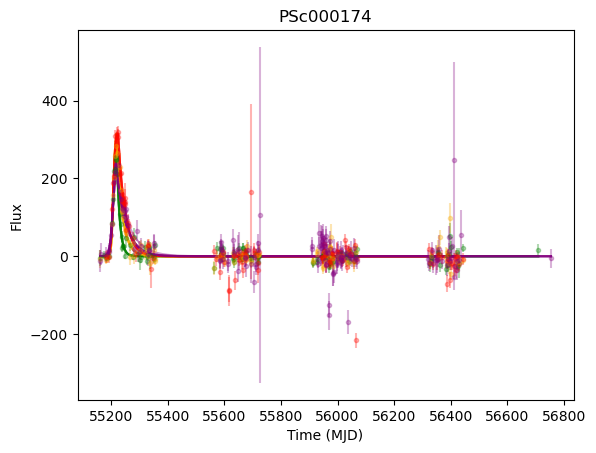

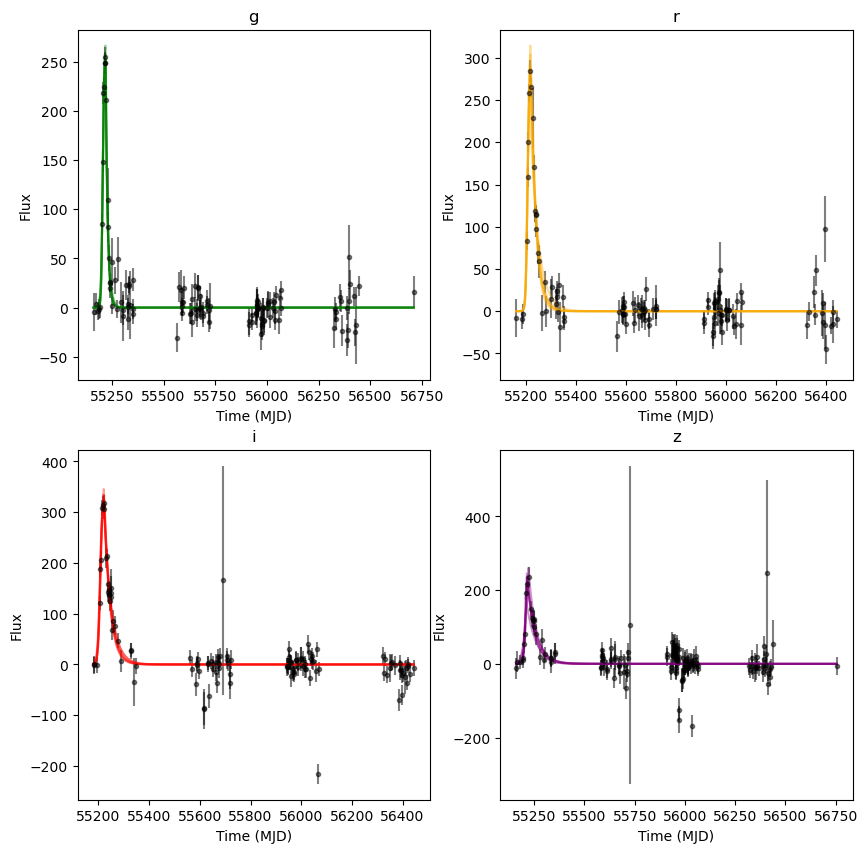

In [1005]:
# colors = ['g','gold','r','purple']
rsams=[]
for i in range(len(star2)):
    
    sam=samples2[i]
    try:
        print(f'band {bands[i]}, no thinning, autocorr =',emcee.autocorr.integrated_time(sam,quiet=True)[0])
        print(f'band {bands[i]}, thinned, autocorr =',emcee.autocorr.integrated_time(sam[::10,:],quiet=True)[0])
    except:
        print('autocorr broke')
        pass
    rsam = sam[np.random.randint(0,sam.shape[0],size=5)]
    rsams.append(rsam)
    mcmc_res = np.percentile(sam,50,axis=0)
    med= np.median(sam,axis=0)
    plt.title('PSc000174')
    plt.xlabel('Time (MJD)')
    plt.ylabel('Flux')
    # plt.scatter(star1[i].MJD,star1[i].FLUXCAL,color=colors[i])
    plt.errorbar(star2[i].MJD,star2[i].FLUXCAL,yerr=star2[i].FLUXCALERR,linestyle='None', marker='.',color=colors[i],alpha=0.3)
    xv=np.linspace(star2[i].MJD.min(),star2[i].MJD.max(),1000)
    plt.plot(xv,fmod(xv,*mcmc_res),color=colors[i],alpha=0.4)
    for j in range(len(rsam)):
        plt.plot(xv,fmod(xv,*rsam[i]),color=colors[i],alpha=0.4)
    # plt.plot(xv,fmod(xv,*med),color=colors[i],alpha=0.1)
plt.figure(figsize=(10,10))
i=0
j=0
for i in range(len(star2)):
    plt.subplot(int(f"22{i+1}"))
    plt.title(bands[i])
    sam=samples2[i][::10,:]
    mcmc_res = np.percentile(sam,50,axis=0)
    med= np.median(sam,axis=0)
    plt.xlabel('Time (MJD)')
    plt.ylabel('Flux')
    # plt.scatter(star1[i].MJD,star1[i].FLUXCAL,color=colors[i])
    plt.errorbar(star2[i].MJD,star2[i].FLUXCAL,yerr=star2[i].FLUXCALERR,linestyle='None', marker='.',color='k',alpha=0.5)
    xv=np.linspace(star2[i].MJD.min(),star2[i].MJD.max(),1000)
    plt.plot(xv,fmod(xv,*mcmc_res),color=colors[i],alpha=0.4)
    j=0
    for j in range(len(rsams[i])):
        plt.plot(xv,fmod(xv,*rsams[i][j]),color=colors[i],alpha=0.4)

## Autocorrelation Example



Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

I am not sure exactly how to obtain the autocorrelation length. I tried above with the function `emcee.autocorr.integrated_time()` which gives a warning when I input the sample of the walkers.
Here is a representative interpretation of a possible way to find the autocorrelation length using one of the walkers with the first parameter in my list which is
$A$. I am using `emcee.autocorr.function_1d()` to find how many zero crossings there are in the autocorrelation function.

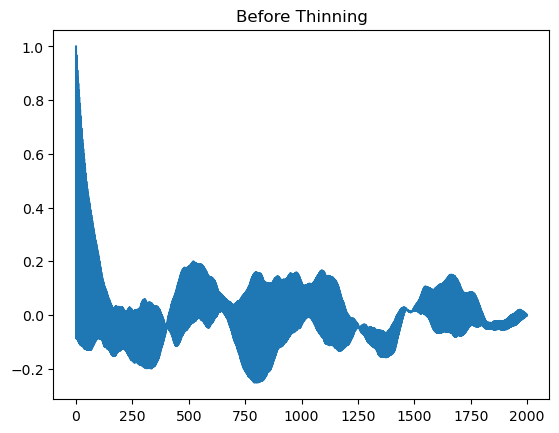

In [1029]:
plt.plot(emcee.autocorr.function_1d(sam[:,0]))
plt.title('Before Thinning');

In [1062]:
wog= emcee.autocorr.function_1d(sam[:,0])
cross =0
vals=[]
for i in range(len(wog)-1):
    if wog[i]>0 and wog[i+1]<0:
        cross+=1
        vals.append(sam[:,0][i])
print('# of crossings =',cross,'\navg input value of crossing =',np.mean(vals))

# of crossings = 744 
avg input value of crossing = 240.0458417790758


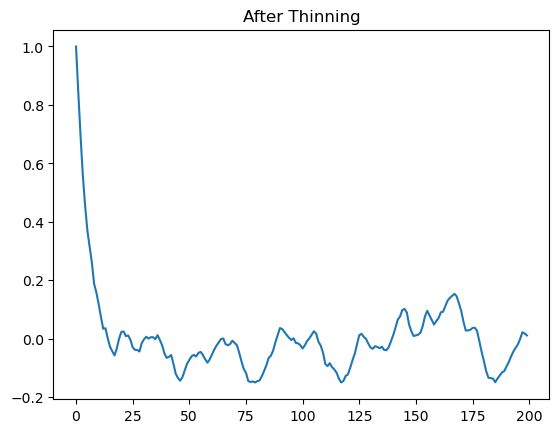

In [1055]:
plt.plot(emcee.autocorr.function_1d(sam[::10,0]))
plt.title('After Thinning');

In [1063]:
wog= emcee.autocorr.function_1d(sam[::10,0])
cross =0
vals=[]
i=0
for i in range(len(wog)-1):
    if wog[i]>0 and wog[i+1]<0:
        cross+=1
        vals.append(sam[::10,0][i])
print('# of crossings =',cross,'\navg input value of crossing =',np.mean(vals))

# of crossings = 10 
avg input value of crossing = 243.54086997626496
